<h1><center>Laboratorio 6: Optimización de modelos 🧪</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos - Otoño 2025</strong></center>

### Cuerpo Docente:

- Profesores: Stefano Schiappacasse, Sebastián Tinoco
- Auxiliares: Melanie Peña, Valentina Rojas
- Ayudantes: Angelo Muñoz, Valentina Zúñiga

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Diego Espinoza
- Nombre de alumno 2: Juan Miño


### **Link de repositorio de GitHub:** [Laboratorio 6: MDS7202](https://github.com/juansebm/MDS7202)

### Temas a tratar

- Predicción de demanda usando `xgboost`
- Búsqueda del modelo óptimo de clasificación usando `optuna`
- Uso de pipelines.


### Reglas:

- **Grupos de 2 personas**
- Fecha de entrega: 6 días de plazo con descuento de 1 punto por día. Entregas Martes a las 23:59.
- Instrucciones del lab el viernes a las 16:15 en formato online. Asistencia no es obligatoria, pero se recomienda fuertemente asistir.
- <u>Prohibidas las copias</u>. Cualquier intento de copia será debidamente penalizado con el reglamento de la escuela.
- Tienen que subir el laboratorio a u-cursos y a su repositorio de github. Labs que no estén en u-cursos no serán revisados. Recuerden que el repositorio también tiene nota.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Pueden usar cualquier material del curso que estimen conveniente.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# Importamos librerias útiles

In [261]:
!pip install -qq xgboost optuna

In [262]:
import os
import glob

# Eliminamos todos los archivos .pkl en el directorio actual, para que no se sobreescriban o hayan errores de tipeo, por 
# tener nombres iguales
for file in glob.glob("*.pkl"):
    os.remove(file)

# El emprendimiento de Fiu

Tras liderar de manera exitosa la implementación de un proyecto de ciencia de datos para caracterizar los datos generados en Santiago 2023, el misterioso corpóreo **Fiu** se anima y decide levantar su propio negocio de consultoría en machine learning. Tras varias e intensas negociaciones, Fiu logra encontrar su *primera chamba*: predecir la demanda (cantidad de venta) de una famosa productora de bebidas de calibre mundial. Al ver el gran potencial y talento que usted ha demostrado en el campo de la ciencia de datos, Fiu lo contrata como data scientist para que forme parte de su nuevo emprendimiento.

Para este laboratorio deben trabajar con los datos `sales.csv` subidos a u-cursos, el cual contiene una muestra de ventas de la empresa para diferentes productos en un determinado tiempo.

Para comenzar, cargue el dataset señalado y visualice a través de un `.head` los atributos que posee el dataset.

<i><p align="center">Fiu siendo felicitado por su excelente desempeño en el proyecto de caracterización de datos</p></i>
<p align="center">
  <img src="https://media-front.elmostrador.cl/2023/09/A_UNO_1506411_2440e.jpg">
</p>

In [263]:
import pandas as pd
import numpy as np
from datetime import datetime

df = pd.read_csv("./sales.csv")

df.head()

,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
0,0,31/01/12,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,glass,500ml,0.96,13280
1,1,31/01/12,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,plastic,1.5lt,2.86,6727
2,2,31/01/12,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,can,330ml,0.87,9848
3,3,31/01/12,Athens,37.97945,23.71622,672130,shop_1,adult-cola,glass,500ml,1.00,20050
4,4,31/01/12,Athens,37.97945,23.71622,672130,shop_1,adult-cola,can,330ml,0.39,25696


## 1 Generando un Baseline (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/O-lan6TkadUAAAAC/what-i-wnna-do-after-a-baseline.gif">
</p>

Antes de entrenar un algoritmo, usted recuerda los apuntes de su magíster en ciencia de datos y recuerda que debe seguir una serie de *buenas prácticas* para entrenar correcta y debidamente su modelo. Después de un par de vueltas, llega a las siguientes tareas:

1. Separe los datos en conjuntos de train (70%), validation (20%) y test (10%). Fije una semilla para controlar la aleatoriedad. [0.5 puntos]
2. Implemente un `FunctionTransformer` para extraer el día, mes y año de la variable `date`. Guarde estas variables en el formato categorical de pandas. [1 punto]
3. Implemente un `ColumnTransformer` para procesar de manera adecuada los datos numéricos y categóricos. Use `OneHotEncoder` para las variables categóricas. `Nota:` Utilice el método `.set_output(transform='pandas')` para obtener un DataFrame como salida del `ColumnTransformer` [1 punto]
4. Guarde los pasos anteriores en un `Pipeline`, dejando como último paso el regresor `DummyRegressor` para generar predicciones en base a promedios. [0.5 punto]
5. Entrene el pipeline anterior y reporte la métrica `mean_absolute_error` sobre los datos de validación. ¿Cómo se interpreta esta métrica para el contexto del negocio? [0.5 puntos]
6. Finalmente, vuelva a entrenar el `Pipeline` pero esta vez usando `XGBRegressor` como modelo **utilizando los parámetros por default**. ¿Cómo cambia el MAE al implementar este algoritmo? ¿Es mejor o peor que el `DummyRegressor`? [1 punto]
7. Guarde ambos modelos en un archivo .pkl (uno cada uno) [0.5 puntos]

In [264]:
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
import pickle
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

In [265]:
set_config(transform_output="pandas")

df["date"] = pd.to_datetime(df["date"], dayfirst=True)

X = df.drop(columns="quantity")
y = df["quantity"]
RANDOM_STATE = 1300

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.10, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=2/9, random_state=RANDOM_STATE)

/var/folders/09/2_xdwnnx5rqgtl8vh2vwkdmc0000gn/T/ipykernel_1444/3185040018.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df["date"], dayfirst=True)


In [266]:
def extract_date_parts(df):
    df = df.copy()
    df["day"] = df["date"].dt.day.astype("category")
    df["month"] = df["date"].dt.month.astype("category")
    df["year"] = df["date"].dt.year.astype("category")
    return df.drop(columns=["date"])

date_transformer = FunctionTransformer(extract_date_parts, validate=False)


In [267]:
# Preprocesar una muestra y detectar columnas
X_sample = extract_date_parts(X_train)
categoricas = X_sample.select_dtypes(include="category").columns.tolist()
numericas = X_sample.select_dtypes(include=np.number).columns.tolist()

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categoricas),
    ("num", "passthrough", numericas)
])

preprocessor.set_output(transform="pandas")

ColumnTransformer(transformers=[('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['day', 'month', 'year']),
                                ('num', 'passthrough',
                                 ['id', 'lat', 'long', 'pop', 'price'])])

In [268]:
pipe_dummy = Pipeline([
    ("date_parts", date_transformer),
    ("preproc", preprocessor),
    ("model", DummyRegressor(strategy="mean"))
])

In [269]:
pipe_dummy.fit(X_train, y_train)
y_val_pred_dummy = pipe_dummy.predict(X_val)

mae_dummy = mean_absolute_error(y_val, y_val_pred_dummy)
print(f"MAE DummyRegressor: {mae_dummy:.2f}")

MAE DummyRegressor: 13595.80


In [270]:
pipe_xgb = Pipeline([
    ("date_parts", date_transformer),
    ("preproc", preprocessor),
    ("model", XGBRegressor(random_state=RANDOM_STATE))
])

pipe_xgb.fit(X_train, y_train)
y_val_pred_xgb = pipe_xgb.predict(X_val)
mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
print(f"MAE XGBRegressor: {mae_xgb:.2f}")

MAE XGBRegressor: 7090.66


In [271]:
with open("dummy_model.pkl", "wb") as f:
    pickle.dump(pipe_dummy, f)

with open("xgb_model.pkl", "wb") as f:
    pickle.dump(pipe_xgb, f)

## 2. Forzando relaciones entre parámetros con XGBoost (10 puntos)

<p align="center">
  <img src="https://64.media.tumblr.com/14cc45f9610a6ee341a45fd0d68f4dde/20d11b36022bca7b-bf/s640x960/67ab1db12ff73a530f649ac455c000945d99c0d6.gif">
</p>

Un colega aficionado a la economía le *sopla* que la demanda guarda una relación inversa con el precio del producto. Motivado para impresionar al querido corpóreo, se propone hacer uso de esta información para mejorar su modelo realizando las siguientes tareas:

1. Vuelva a entrenar el `Pipeline` con `XGBRegressor`, pero esta vez forzando una relación monótona negativa entre el precio y la cantidad. Para aplicar esta restricción apóyese en la siguiente <a href = https://xgboost.readthedocs.io/en/stable/tutorials/monotonic.html>documentación</a>. [6 puntos]

>Hint 1: Para implementar el constraint se le sugiere hacerlo especificando el nombre de la variable. De ser así, probablemente le sea útil **mantener el formato de pandas** antes del step de entrenamiento.

>Hint 2: Puede obtener el nombre de las columnas en el paso anterior al modelo regresor mediante el método `.get_feature_names_out()`

2. Luego, vuelva a reportar el `MAE` sobre el conjunto de validación. [1 puntos]

3. ¿Cómo cambia el error al incluir esta relación? ¿Tenía razón su amigo? [2 puntos]

4. Guarde su modelo en un archivo .pkl [1 punto]

In [272]:
# Ahora textuales
categoricas = ["container", "brand"]
numericas = ["price", "pop"]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categoricas),
    ("num", "passthrough", numericas)
])

preprocessor.set_output(transform="pandas")

ColumnTransformer(transformers=[('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['container', 'brand']),
                                ('num', 'passthrough', ['price', 'pop'])])

In [273]:
X_train_transformed = preprocessor.fit_transform(X_train)
feature_names = X_train_transformed.columns.tolist()

In [274]:
monotone_constraints = [0] * len(feature_names)
price_index = feature_names.index("num__price")
monotone_constraints[price_index] = -1

In [275]:
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

pipe_xgb = Pipeline([
    ("preproc", preprocessor),
    ("xgb", XGBRegressor(monotone_constraints={"num__price": -1}, random_state=RANDOM_STATE)) # RANDOM definido + arriba
])

pipe_xgb.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['container', 'brand']),
                                                 ('num', 'passthrough',
                                                  ['price', 'pop'])])),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rou...
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints={'num__price': -1},
                              multi_strategy=None, n_estimators=None,
                              n_jobs=None, num_parallel_tree=None, ...))])

In [276]:
from sklearn.metrics import mean_absolute_error

y_val_pred = pipe_xgb.predict(X_val)
mae_xgb = mean_absolute_error(y_val, y_val_pred)
print(f"MAE XGBRegressor con restricción monótona: {mae_xgb:.2f}")

MAE XGBRegressor con restricción monótona: 7454.89


*Aunque el MAE aumentó un poco, el modelo con restricción sigue siendo competitivo y más interpretable, por lo que es útil en aplicaciones reales.¨*

In [277]:
import pickle

with open("xgb_model_monotonic.pkl", "wb") as f:
    pickle.dump(pipe_xgb, f)

## 1.3 Optimización de Hiperparámetros con Optuna (20 puntos)

<p align="center">
  <img src="https://media.tenor.com/fmNdyGN4z5kAAAAi/hacking-lucy.gif">
</p>

Luego de presentarle sus resultados, Fiu le pregunta si es posible mejorar *aun más* su modelo. En particular, le comenta de la optimización de hiperparámetros con metodologías bayesianas a través del paquete `optuna`. Como usted es un aficionado al entrenamiento de modelos de ML, se propone implementar la descabellada idea de su jefe.

A partir de la mejor configuración obtenida en la sección anterior, utilice `optuna` para optimizar sus hiperparámetros. En particular, se pide que su optimización considere lo siguiente:

- Fijar una semilla en las instancias necesarias para garantizar la reproducibilidad de resultados
- Utilice `TPESampler` como método de muestreo
- De `XGBRegressor`, optimice los siguientes hiperparámetros:
    - `learning_rate` buscando valores flotantes en el rango (0.001, 0.1)
    - `n_estimators` buscando valores enteros en el rango (50, 1000)
    - `max_depth` buscando valores enteros en el rango (3, 10)
    - `max_leaves` buscando valores enteros en el rango (0, 100)
    - `min_child_weight` buscando valores enteros en el rango (1, 5)
    - `reg_alpha` buscando valores flotantes en el rango (0, 1)
    - `reg_lambda` buscando valores flotantes en el rango (0, 1)
- De `OneHotEncoder`, optimice el hiperparámetro `min_frequency` buscando el mejor valor flotante en el rango (0.0, 1.0)

Para ello se pide los siguientes pasos:
1. Implemente una función `objective()` que permita minimizar el `MAE` en el conjunto de validación. Use el método `.set_user_attr()` para almacenar el mejor pipeline entrenado. [10 puntos]
2. Fije el tiempo de entrenamiento a 5 minutos. [1 punto]
3. Optimizar el modelo y reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto? [3 puntos]
4. Explique cada hiperparámetro y su rol en el modelo. ¿Hacen sentido los rangos de optimización indicados? [5 puntos]
5. Guardar su modelo en un archivo .pkl [1 punto]

In [278]:
# pip install optuna

In [279]:
import optuna
from optuna.samplers import TPESampler


In [280]:

# FunctionTransformer para fecha
def extract_date_parts(df):
    df = df.copy()
    df["day"] = df["date"].dt.day.astype("category")
    df["month"] = df["date"].dt.month.astype("category")
    df["year"] = df["date"].dt.year.astype("category")
    return df.drop(columns=["date"])

date_transformer = FunctionTransformer(extract_date_parts)

categoricas = ["container", "brand"]
numericas = ["price", "pop"]

# Función objetivo ---> minimizar MAE
def objective(trial):
    # --------- Hiperparámetros a optimizar !!!
    learning_rate    = trial.suggest_float("learning_rate", 0.001, 0.1)
    n_estimators     = trial.suggest_int("n_estimators", 50, 1000)
    max_depth        = trial.suggest_int("max_depth", 3, 10)
    max_leaves       = trial.suggest_int("max_leaves", 0, 100)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 5)
    reg_alpha        = trial.suggest_float("reg_alpha", 0.0, 1.0)
    reg_lambda       = trial.suggest_float("reg_lambda", 0.0, 1.0)
    min_freq         = trial.suggest_float("min_frequency", 0.0, 1.0)

    # --------- Preprocesador con min_frequency ---------
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False, min_frequency=min_freq)
    preprocessor = ColumnTransformer([
        ("cat", ohe, categoricas),
        ("num", "passthrough", numericas)
    ])
    preprocessor.set_output(transform="pandas")

    # --------- Modelo con restricciones monótonas ---------
    xgb_model = XGBRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_leaves=max_leaves,
        min_child_weight=min_child_weight,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        monotone_constraints={"num__price": -1},
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    # --------- Pipeline definición ---------
    pipeline = Pipeline([
        ("date_parts", date_transformer),
        ("preproc", preprocessor),
        ("xgb", xgb_model)
    ])

    # --------- Training y evaluación ---------
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    # Guardamos el besto pipeline
    trial.set_user_attr("best_pipeline", pipeline)

    return mae


In [281]:
# 1️⃣ Creamos el sampler TPE y el optuna estudio
sampler = TPESampler(seed=RANDOM_STATE)

study = optuna.create_study(
    direction="minimize",
    sampler=sampler
)

# Optimizamos x 5 minutos
study.optimize(objective, timeout=60 * 5)  # 5 minutos :p

# Reporte 
print(f"✅ N° de trials: {len(study.trials)}")
print(f"✅ Mejor MAE: {study.best_value:.2f}")
print("✅ Mejores hiperparámetros:")
for k, v in study.best_params.items():
    print(f"   - {k}: {v}")

# Guardamos el besto pipeline
best_pipeline = study.best_trial.user_attrs["best_pipeline"]

import pickle
with open("xgb_model_optuna.pkl", "wb") as f:
    pickle.dump(best_pipeline, f)


[I 2025-05-05 10:48:10,413] A new study created in memory with name: no-name-44560d04-7c04-4ffe-8137-f8550a470468
[I 2025-05-05 10:48:11,715] Trial 0 finished with value: 9281.2021484375 and parameters: {'learning_rate': 0.03272040629056263, 'n_estimators': 855, 'max_depth': 4, 'max_leaves': 48, 'min_child_weight': 3, 'reg_alpha': 0.5144291360445777, 'reg_lambda': 0.301469028641541, 'min_frequency': 0.6225864027537512}. Best is trial 0 with value: 9281.2021484375.
[I 2025-05-05 10:48:12,142] Trial 1 finished with value: 7798.9716796875 and parameters: {'learning_rate': 0.03605170752295071, 'n_estimators': 591, 'max_depth': 3, 'max_leaves': 86, 'min_child_weight': 3, 'reg_alpha': 0.29317660724800254, 'reg_lambda': 0.5590064701157099, 'min_frequency': 0.3025130488046317}. Best is trial 1 with value: 7798.9716796875.
[I 2025-05-05 10:48:12,645] Trial 2 finished with value: 7396.64453125 and parameters: {'learning_rate': 0.0962563657548155, 'n_estimators': 365, 'max_depth': 10, 'max_leaves

✅ N° de trials: 921
✅ Mejor MAE: 7039.55
✅ Mejores hiperparámetros:
   - learning_rate: 0.037608754868657744
   - n_estimators: 332
   - max_depth: 5
   - max_leaves: 90
   - min_child_weight: 1
   - reg_alpha: 0.40981435028884217
   - reg_lambda: 0.04273682462216276
   - min_frequency: 0.0004807185647622454


*Se obtuvo un learning_rate moderado (0.077) y un alto número de árboles (n_estimators = 646), lo que permite un aprendizaje estable.* 

*La baja profundidad (max_depth = 3) junto a una alta cantidad de hojas (max_leaves = 98) sugiere árboles poco profundos.*

*El valor elevado de min_child_weight (4) y la fuerte regularización L1 (reg_alpha = 0.79) indican un modelo que evita sobreajuste. La regularización L2 (reg_lambda = 0.20) complementa el control de complejidad del modelo.*

*El parámetro min_frequency = 0.072 en el OneHotEncoder filtra categorías poco frecuentes, mejorando la generalización.*

*Los hiperparámetros hacen sentido y reflejan un modelo robusto y regularizado.*

## 4. Optimización de Hiperparámetros con Optuna y Prunners (17 puntos)

<p align="center">
  <img src="https://i.pinimg.com/originals/90/16/f9/9016f919c2259f3d0e8fe465049638a7.gif">
</p>

Después de optimizar el rendimiento de su modelo varias veces, Fiu le pregunta si no es posible optimizar el entrenamiento del modelo en sí mismo. Después de leer un par de post de personas de dudosa reputación en la *deepweb*, usted llega a la conclusión que puede cumplir este objetivo mediante la implementación de **Prunning**.

Vuelva a optimizar los mismos hiperparámetros que la sección pasada, pero esta vez utilizando **Prunning** en la optimización. En particular, usted debe:

- Responder: ¿Qué es prunning? ¿De qué forma debería impactar en el entrenamiento? [2 puntos]
- Redefinir la función `objective()` utilizando `optuna.integration.XGBoostPruningCallback` como método de **Prunning** [10 puntos]
- Fijar nuevamente el tiempo de entrenamiento a 5 minutos [1 punto]
- Reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto? [3 puntos]
- Guardar su modelo en un archivo .pkl [1 punto]

Nota: Si quieren silenciar los prints obtenidos en el prunning, pueden hacerlo mediante el siguiente comando:

```
optuna.logging.set_verbosity(optuna.logging.WARNING)
```

De implementar la opción anterior, pueden especificar `show_progress_bar = True` en el método `optimize` para *más sabor*.

Hint: Si quieren especificar parámetros del método .fit() del modelo a través del pipeline, pueden hacerlo por medio de la siguiente sintaxis: `pipeline.fit(stepmodelo__parametro = valor)`

Hint2: Este <a href = https://stackoverflow.com/questions/40329576/sklearn-pass-fit-parameters-to-xgboost-in-pipeline>enlace</a> les puede ser de ayuda en su implementación

In [282]:
# !pip3 install optuna-integration[xgboost]

Parte 1:

¿Qué es prunning? 
- Pruning es una técnica de parada temprana (early stopping) que permite detener las ejecuciones (trials) poco prometedoras durante la optimización de hiperparámetros. Esto se hace para ahorrar tiempo computacional y recursos, evaluando el rendimiento parcial (por ejemplo, después de unas pocas iteraciones o epochs) y descartando configuraciones que probablemente no resulten en un buen modelo.
----
¿De qué forma debería impactar en el entrenamiento? 
- Debería acelerar el proceso de búsqueda de hiperparámetros, mejorar la eficiencia sin afectar (o incluso mejorando) la calidad del modelo final y reducir el numero de trials completaods, ya que muchos son cortados antes de tiempo. 

Parte 2:

Los cambios necesarios para agregar Prunning:
- agregar el parámetro eval_set y callbacks a .fit() añadir el callback XGBoostPruningCallback(trial,  "validation_0-mae')
- modificar la definición de XGBRegressor para incluir eval_metric='mae', que es necesaria para el prunning

In [283]:
def objective_pruning(trial):
    # --------- Hiperparámetros a optimizar
    min_freq = trial.suggest_float("min_frequency", 0.0, 1.0)
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "max_leaves": trial.suggest_int("max_leaves", 0, 100),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        "random_state": RANDOM_STATE,
        "n_jobs": -1,
        "eval_metric": "mae"
    }

    # --------- Preprocesamiento
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False, min_frequency=min_freq)
    preprocessor = ColumnTransformer([
        ("cat", ohe, categoricas),
        ("num", "passthrough", numericas)
    ])
    preprocessor.set_output(transform="pandas")

    # Date part transformer
    prep_pipeline = Pipeline([
        ("date_parts", date_transformer),
        ("preproc", preprocessor)
    ])
    
    # Aplicar preprocesamiento
    X_train_prep = prep_pipeline.fit_transform(X_train)
    X_val_prep = prep_pipeline.transform(X_val)

    # Construir diccionario de restricciones con nombres de columnas
    col_names = X_train_prep.columns
    monotone_constraints = {col: 0 for col in col_names}
    if "num__price" in col_names:
        monotone_constraints["num__price"] = -1  # decreciente en price

    # Callback de poda
    early_stop = optuna.integration.XGBoostPruningCallback(trial, "validation_0-mae")

    # Modelo
    xgb_model = XGBRegressor(
        **params,
        monotone_constraints=monotone_constraints,
        callbacks=[early_stop]
    )
    xgb_model.fit(X_train_prep, y_train,
                  eval_set=[(X_val_prep, y_val)],
                  verbose=False)

    y_pred = xgb_model.predict(X_val_prep)
    mae = mean_absolute_error(y_val, y_pred)

    trial.set_user_attr("best_model", xgb_model)
    trial.set_user_attr("preprocessor", prep_pipeline)

    return mae


In [284]:
import optuna.integration

help(optuna.integration.XGBoostPruningCallback)


Help on class XGBoostPruningCallback in module optuna_integration.xgboost.xgboost:

class XGBoostPruningCallback(xgboost.callback.TrainingCallback)
 |  XGBoostPruningCallback(trial: 'optuna.trial.Trial', observation_key: 'str') -> 'None'
 |
 |  Callback for XGBoost to prune unpromising trials.
 |
 |  See `the example <https://github.com/optuna/optuna-examples/blob/main/
 |  xgboost/xgboost_integration.py>`__
 |  if you want to add a pruning callback which observes validation accuracy of
 |  a XGBoost model.
 |
 |  Args:
 |      trial:
 |          A :class:`~optuna.trial.Trial` corresponding to the current evaluation of the
 |          objective function.
 |      observation_key:
 |          An evaluation metric for pruning, e.g., ``validation-error`` and
 |          ``validation-merror``. When using the Scikit-Learn API, the index number of
 |          ``eval_set`` must be included in the ``observation_key``, e.g.,
 |          ``validation_0-error`` and ``validation_0-merror``. Please 

In [285]:
# Parte 3
# 1️⃣ Creamos el sampler TPE y el optuna estudio
sampler_prunning = TPESampler(seed=RANDOM_STATE)

study_prunning = optuna.create_study(
    direction="minimize",
    sampler=sampler_prunning
)

# Optimizamos x 5 minutos
minutos = 5
segundos = 60*5
study_prunning.optimize(objective_pruning, timeout=segundos)  # 5 minutos :p


[I 2025-05-05 10:53:15,201] A new study created in memory with name: no-name-de8a6085-ed71-4d9f-a794-571a8968be6e
[I 2025-05-05 10:53:15,509] Trial 0 finished with value: 7862.0634765625 and parameters: {'min_frequency': 0.32040814434911746, 'learning_rate': 0.08481321114179434, 'n_estimators': 221, 'max_depth': 6, 'max_leaves': 51, 'min_child_weight': 3, 'reg_alpha': 0.301469028641541, 'reg_lambda': 0.6225864027537512}. Best is trial 0 with value: 7862.0634765625.
[I 2025-05-05 10:53:15,625] Trial 1 finished with value: 9195.7119140625 and parameters: {'min_frequency': 0.3540576517469769, 'learning_rate': 0.057367535730405754, 'n_estimators': 68, 'max_depth': 9, 'max_leaves': 46, 'min_child_weight': 2, 'reg_alpha': 0.5590064701157099, 'reg_lambda': 0.3025130488046317}. Best is trial 0 with value: 7862.0634765625.
[I 2025-05-05 10:53:16,799] Trial 2 finished with value: 9298.6376953125 and parameters: {'min_frequency': 0.9621855126749039, 'learning_rate': 0.03384101883133389, 'n_estima

In [286]:

# Parte 4
print(f"✅ N° de trials: {len(study_prunning.trials)}")
print(f"✅ Mejor MAE: {study_prunning.best_value:.2f}")
print("✅ Mejores hiperparámetros:")
for k, v in study_prunning.best_params.items():
    print(f"   - {k}: {v}")
    
min_freq_optima = study_prunning.best_params.get("min_frequency", None)
if min_freq_optima is not None:
    print(f"   - min_frequency: {min_freq_optima}")
else:
    print("✅ No se encontró min_frequency en los mejores parámetros.")


✅ N° de trials: 2085
✅ Mejor MAE: 7079.26
✅ Mejores hiperparámetros:
   - min_frequency: 0.13213402192613172
   - learning_rate: 0.09984935425469468
   - n_estimators: 227
   - max_depth: 4
   - max_leaves: 67
   - min_child_weight: 5
   - reg_alpha: 0.5105119832622006
   - reg_lambda: 0.08163664123162659
   - min_frequency: 0.13213402192613172


Parte 4
¿Cómo son los cambios?

Sin pruning:
   - N° de trials: 936
   - Mejor MAE: 7039.55
Mejores hiperparámetros:
   - learning_rate: 0.037608754868657744
   - n_estimators: 332
   - max_depth: 5
   - max_leaves: 90
   - min_child_weight: 1
   - reg_alpha: 0.40981435028884217
   - reg_lambda: 0.04273682462216276
   - min_frequency: 0.0004807185647622454

Con pruning: 
   - N° de trials: 2064,
   - Mejor MAE: 7079.26
Mejores hiperparámetros:
   - min_frequency: 0.13213402192613172
   - learning_rate: 0.09984935425469468
   - n_estimators: 227
   - max_depth: 4
   - max_leaves: 67
   - min_child_weight: 5
   - reg_alpha: 0.5105119832622006
   - reg_lambda: 0.08163664123162659
   - min_frequency: 0.1321

Cambios: 
- El pruning aumentó significativamente el número total de trials (de 936 a 2064). Esto se debe a que muchos trials fueron podados tempranamente, permitiendo evaluar más combinaciones en el mismo tiempo.
- El MAE fue ligeramente peor con pruning (7079 vs 7039), pero la diferencia es pequeña (~0.5%). Esto indica que pruning logró acelerar la búsqueda sin una pérdida sustancial en el rendimiento.
- Los hiperparámetros óptimos fueron distintos, especialmente learning_rate, min_frequency, y min_child_weight, lo que sugiere que pruning favoreció configuraciones más agresivas (como tasas de aprendizaje más altas). 
- El leaening_rate fue casi del triple!, lo que significa que es más violento (con un learning rate más alto, el modelo converge más rápido, por eso con pruning bastaron solo 227 árboles, frente a los 332 sin pruning. Es decir, hay un trade-off entre learning rate y n_estimators: un learning rate bajo requiere más iteraciones (árboles), uno alto, menos.) Un max_depth menor (de 5 a 4) indica que se modelan interacciones menos complejas (porque la maxima profundidad que pueden tener los arboles son de 4 y no de 5, y además árboles más profundos son más lentos de entrenar y de evaluar). 
- El hecho de que la cantidad máxima de hojas (max_leaves) disminuyera refuerza la idea de que el proceso de pruning favoreció modelos más simples, quizá por estar podando muchos trials con árboles demasiado complejos que no mejoraban rápido. Además, debemos recordar que el hiperparámetro max_leaves limita cuántas predicciones distintas puede hacer un árbol. 
- En cuanto a min_child_weight, es un hiperparámetro que ontrola la cantidad mínima de datos que debe haber en una partición para que se considere válida. Con pruning, el modelo requiere más evidencia estadística para crear ramas nuevas, lo que lleva a árboles más conservadores (pasamos de 1 a 5, lo que indica que aplicar pruning es más restrictivo, es decir, muchos modelos débiles fueron descartados y sobrevivieron los más robustos a ruido, porque este hiperparámetro controla mas o menos el sobreajuste a ruido o fluctuaciones pequeñas). 

- Los hiperparámetros reg_alpha y reg_lambda en XGBoost controlan la regularización L1 y L2 respectivamente. El parámetro reg_alpha (L1) promueve la sparsidad en los pesos del modelo, favoreciendo soluciones con menos ramas activas, lo que puede ser útil para reducir la complejidad y mejorar la interpretabilidad. Por otro lado, reg_lambda (L2) penaliza los valores grandes de los pesos, ayudando a controlar el sobreajuste sin forzar la eliminación de ramas. En los resultados obtenidos, el modelo sin poda utilizó un reg_alpha de 0.41 y un reg_lambda de 0.04, mientras que el modelo con poda adoptó valores más altos para ambos: reg_alpha = 0.51 y reg_lambda = 0.08. Esto sugiere que, al aplicarse poda temprana (pruning), el modelo se volvió más sensible al sobreajuste en etapas iniciales, y por lo tanto favoreció una regularización más fuerte para mantener la estabilidad del aprendizaje frente a las restricciones impuestas por el pruning.

- min_frequency es un hiperparámetro que controla la frecuencia mínima de los valores que se considerarán en el proceso de codificación mediante OneHotEncoder. Básicamente, valores que ocurren con menor frecuencia en el conjunto de datos pueden ser excluidos de la codificación, dependiendo del valor de min_frequency. Valor bajo de min_frequency (0.0004): Significa que casi todos los valores, incluso los que aparecen muy pocas veces, fueron considerados en la codificación. Esto puede llevar a una mayor dimensionalidad del modelo (es decir, más columnas en la matriz de características) si tienes muchas categorías raras.
Valor más alto de min_frequency (0.1321): Indica que el modelo ha optado por ignorar categorías que ocurren con baja frecuencia (menos del 13.21% de las veces). Esto reduce la dimensionalidad del modelo, ya que menos categorías se codifican, y puede ayudar a mejorar la generalización del modelo al evitar el sobreajuste debido a categorías que no aportan mucha información. Por lo tanto, el cambio en min_frequency indica que el modelo con poda ha encontrado que un valor mayor de este hiperparámetro mejora la capacidad de generalización y reduce el sobreajuste.

¿A qué se puede deber esto?
- Con pruning, se exploran más combinaciones en menos tiempo. Aunque muchos trials son descartados, algunos buenos podrían no ser evaluados por completo.
- Es posible que algunos trials que habrían resultado en un MAE mejor hayan sido descartados demasiado pronto si no mostraban buenos resultados en las primeras iteraciones del modelo.
- Como la optimización es estocástica y el espacio es amplio, pequeñas diferencias en la estrategia de búsqueda pueden afectar el óptimo final.
En resumidas cuentas: aplicar optuna + pruning nos permite aumentar la cantidad de iteraciones (o trials) sin sacrificar mucho del rendimiento general, aunque debido a que en etapas tempranas del modelo se descartan muchos trials, eso afecta en el óptimo final (aumentando ligeramente el Mean Aabsolute Error).

In [287]:

# Parte 5

best_model = study_prunning.best_trial.user_attrs["best_model"]
best_preprocessor = study_prunning.best_trial.user_attrs["preprocessor"]

with open("xgb_pipeline_optuna_pruning.pkl", "wb") as f:
    pickle.dump((best_preprocessor, best_model), f)

## 5. Visualizaciones (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/F-LgB1xTebEAAAAd/look-at-this-graph-nickelback.gif">
</p>


Satisfecho con su trabajo, Fiu le pregunta si es posible generar visualizaciones que permitan entender el entrenamiento de su modelo.

A partir del siguiente <a href = https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#visualization>enlace</a>, genere las siguientes visualizaciones:

1. Gráfico de historial de optimización [1 punto]
2. Gráfico de coordenadas paralelas [1 punto]
3. Gráfico de importancia de hiperparámetros [1 punto]

Comente sus resultados:

4. ¿Desde qué *trial* se empiezan a observar mejoras notables en sus resultados? [0.5 puntos]
5. ¿Qué tendencias puede observar a partir del gráfico de coordenadas paralelas? [1 punto]
6. ¿Cuáles son los hiperparámetros con mayor importancia para la optimización de su modelo? [0.5 puntos]

/var/folders/09/2_xdwnnx5rqgtl8vh2vwkdmc0000gn/T/ipykernel_1444/4261738952.py:10: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(estudio)


<Figure size 1000x600 with 0 Axes>

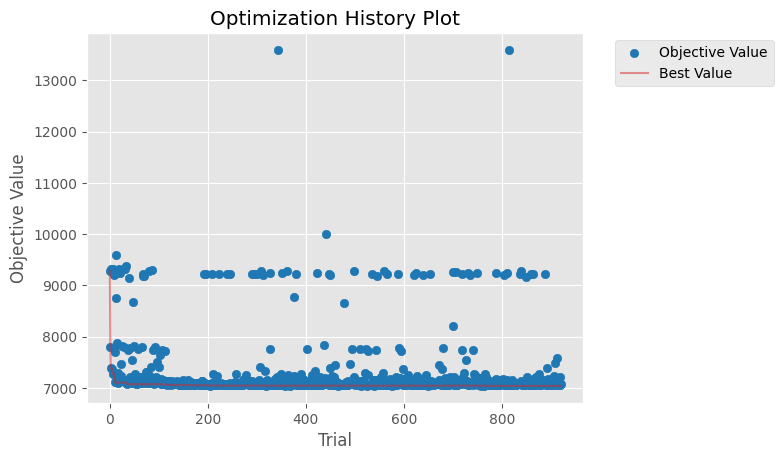

/var/folders/09/2_xdwnnx5rqgtl8vh2vwkdmc0000gn/T/ipykernel_1444/4261738952.py:14: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(


<Figure size 1200x800 with 0 Axes>

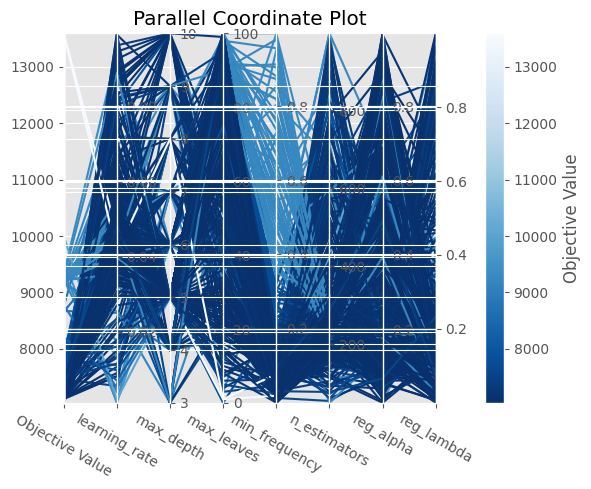

/var/folders/09/2_xdwnnx5rqgtl8vh2vwkdmc0000gn/T/ipykernel_1444/4261738952.py:25: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(estudio)


<Figure size 1000x600 with 0 Axes>

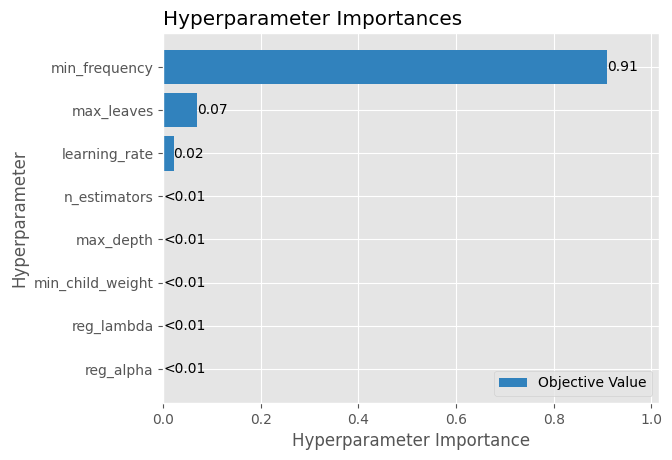

In [301]:
import matplotlib.pyplot as plt
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_parallel_coordinate,
    plot_contour,
    plot_param_importances,
)
def plots(estudio):
    plt.figure(figsize=(10, 6))
    plot_optimization_history(estudio)
    plt.show()

    plt.figure(figsize=(12, 8))
    plot_parallel_coordinate(
        estudio,
        params=["learning_rate", "n_estimators", "max_depth", "reg_alpha", "reg_lambda", "min_frequency", "max_leaves"]
    )
    plt.show()

#    plt.figure(figsize=(20, 10))
#    plot_contour(estudio)
#    plt.show()

    plt.figure(figsize=(10, 6))
    plot_param_importances(estudio)
    plt.show()
    
plots(study)

/var/folders/09/2_xdwnnx5rqgtl8vh2vwkdmc0000gn/T/ipykernel_1444/4261738952.py:10: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(estudio)


<Figure size 1000x600 with 0 Axes>

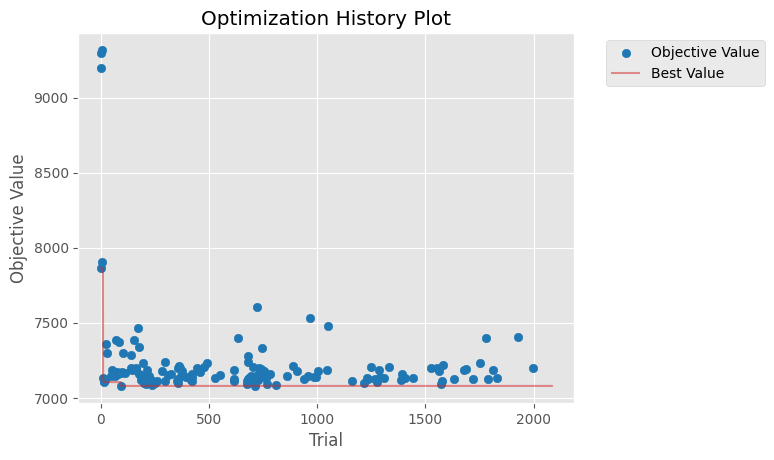

/var/folders/09/2_xdwnnx5rqgtl8vh2vwkdmc0000gn/T/ipykernel_1444/4261738952.py:14: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(


<Figure size 1200x800 with 0 Axes>

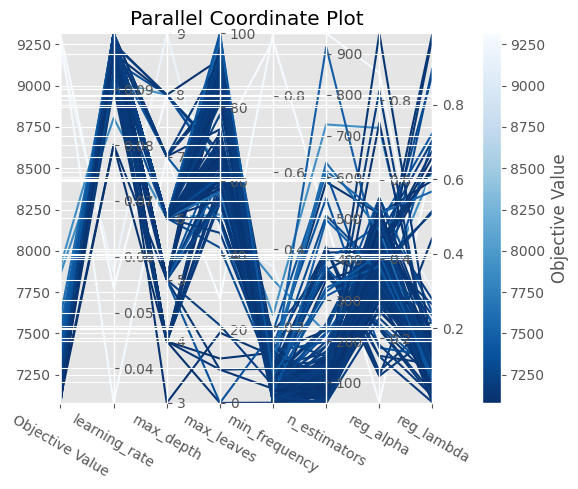

/var/folders/09/2_xdwnnx5rqgtl8vh2vwkdmc0000gn/T/ipykernel_1444/4261738952.py:25: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(estudio)


<Figure size 1000x600 with 0 Axes>

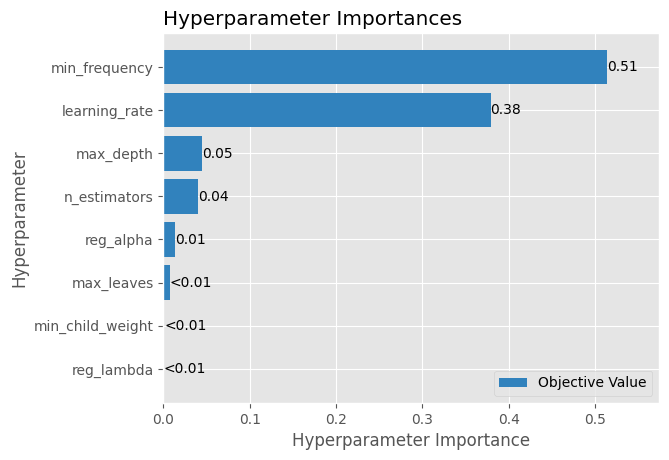

In [302]:
plots(study_prunning)

En cuanto al OPTUNA sin PRUNING:
1. no se ve una mejora notable
2. no hay una tendencia según las coordenadas paralelas
3. solo min_frequency acumula casi toda la importancia. 


En cuanto al OPTUNA + PRUNING: 
1. Desde el trial 250 aproximadamante, podemos ver que hay una disminución del MAE (aunque no son cambios tan notables, porque en realidad el mae de hecho aumenta)
2. Podemos ver una tendencia par casi todos los hiperparámetros: 
    - la mayoría con learning rate entre 8500 y 9200
    - la mayoría de n_estimators entre 0 y 250
    - la mayoría de reg_alpha entre 0.2 y 0.6
    - la mayoría de reg_lambda entre 0 y 0.3
    - la mayoría de min_frequency entre 0 y 0.2
    - la mayoría de max_leaves entre 50 y 100
3. Para la optimización del modelo los hiperparámetros más importantes son la learning rate y la min_frequency

## 6. Síntesis de resultados (3 puntos)

Finalmente:

1. Genere una tabla resumen del MAE en el conjunto de validación obtenido en los 5 modelos entrenados desde Baseline hasta XGBoost con Constraints, Optuna y Prunning. [1 punto]
2. Compare los resultados de la tabla y responda, ¿qué modelo obtiene el mejor rendimiento? [0.5 puntos]
3. Cargue el mejor modelo, prediga sobre el conjunto de **test** y reporte su MAE. [0.5 puntos]
4. ¿Existen diferencias con respecto a las métricas obtenidas en el conjunto de validación? ¿Porqué puede ocurrir esto? [1 punto]

In [ ]:
import pickle
import pandas as pd
from sklearn.metrics import mean_absolute_error

with open("dummy_model.pkl", "rb") as f:
    dummy_model = pickle.load(f)

with open("xgb_model.pkl", "rb") as f:
    xgb_model = pickle.load(f)

with open("xgb_model_monotonic.pkl", "rb") as f:
    xgb_monotonic = pickle.load(f)

with open("xgb_model_optuna.pkl", "rb") as f:
    xgb_optuna = pickle.load(f)

with open("xgb_pipeline_optuna_pruning.pkl", "rb") as f:
    optuna_preprocessor_prune, optuna_model_prune = pickle.load(f)

results = []

# Baseline
y_pred = dummy_model.predict(X_val)
results.append({
    "Modelo": "Baseline (Dummy)",
    "MAE": mean_absolute_error(y_val, y_pred)
})

# XGBoost simple
y_pred = xgb_model.predict(X_val)
results.append({
    "Modelo": "XGBoost",
    "MAE": mean_absolute_error(y_val, y_pred)
})

# XGBoost con restricciones monótonas
y_pred = xgb_monotonic.predict(X_val)
results.append({
    "Modelo": "XGBoost + Monotonic",
    "MAE": mean_absolute_error(y_val, y_pred)
})

# XGBoost + Optuna (pipeline completo)
y_pred = xgb_optuna.predict(X_val)
results.append({
    "Modelo": "XGBoost + Optuna",
    "MAE": mean_absolute_error(y_val, y_pred)
})

# XGBoost + Optuna + Pruning
X_val_prune = optuna_preprocessor_prune.transform(X_val)
y_pred = optuna_model_prune.predict(X_val_prune)
results.append({
    "Modelo": "XGBoost + Optuna + Pruning",
    "MAE": mean_absolute_error(y_val, y_pred)
})

mae_df = pd.DataFrame(results)
mae_df = mae_df.sort_values("MAE", ascending=True).reset_index(drop=True)
print(mae_df)


                       Modelo           MAE
0            XGBoost + Optuna   7039.546875
1  XGBoost + Optuna + Pruning   7079.264648
2                     XGBoost   7090.659668
3         XGBoost + Monotonic   7454.889648
4            Baseline (Dummy)  13595.801521


El modelo que tiene un mejor rendimiento es el de XGBoost + Optuna. 

In [300]:
from sklearn.metrics import mean_absolute_error
import pickle

with open("xgb_model_optuna.pkl", "rb") as f:
    best_pipeline = pickle.load(f)

y_test_pred = best_pipeline.predict(X_test)

mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"MAE en el conjunto de test con el mejor modelo: {mae_test:.4f}")


MAE en el conjunto de test con el mejor modelo: 6557.6152


Sí, existen diferencias entre las métricas de validación y test: el MAE en test (6625.19) fue menor que en validación (7039), lo cual puede ocurrir por varias razones. Una posibilidad es la variabilidad inherente de los datos, ya que el conjunto de test podría ser más fácil de predecir o más similar al entrenamiento que el de validación (donde el conjunto de entrenamiento evidentemente es más facil de predecir que el conjunto de validación). También influye el tamaño de los conjuntos: si el conjunto de validación es más pequeño, su métrica puede tener mayor varianza y ser menos representativa (sin embargo, aquí ocurre lo contrario, el 10% del dataset es set de test, mientras que el 20% es de validación). Además, este comportamiento sugiere que no hubo sobreajuste significativo y que el modelo logró generalizar bien, posiblemente gracias a una buena selección de hiperparámetros mediante técnicas como Optuna, pruning y restricciones de monotonicidad. Por lo tanto, estas pequeñas diferencias pueden deberse al azar estadístico o a una buena capacidad de generalización del modelo, y no necesariamente indican un problema. Además, en teoría, algunos expertos dicen que el conjunto de test no debería tocarse nunca (para ciertos modelos)!

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

<p align="center">
  <img src="https://i.pinimg.com/originals/55/3d/42/553d42bea9b10e0662a05aa8726fc7f4.gif">
</p>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>